In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Carrega todos os membros em um dataset do dask/xarray (a concatenação é feita na dimensão do ensemble)
ens_anl_oper = xr.open_mfdataset("ens_oper/2019070200/*/GPOS*20190702002019070200P.icn.TQ0126L028.grb", engine="pynio", concat_dim="ens")

In [3]:
ens_anl_oper

<xarray.Dataset>
Dimensions:         (ens: 15, g4_lat_0: 192, g4_lon_1: 384, lv_ISBL2: 9)
Coordinates:
  * lv_ISBL2        (lv_ISBL2) int32 50 200 250 300 500 700 850 925 1000
  * g4_lat_0        (g4_lat_0) float32 89.284225 88.357 ... -88.357 -89.284225
  * g4_lon_1        (g4_lon_1) float32 0.0 0.9375013 ... 358.1255 359.063
Dimensions without coordinates: ens
Data variables:
    PSNM_GDS4_MSL   (ens, g4_lat_0, g4_lon_1) float32 dask.array<shape=(15, 192, 384), chunksize=(1, 192, 384)>
    ZGEO_GDS4_ISBL  (ens, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    TEMP_GDS4_ISBL  (ens, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    UVEL_GDS4_ISBL  (ens, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    VVEL_GDS4_ISBL  (ens, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 3

In [4]:
# Renomeia das dimensões do dataset
nens_anl_oper = ens_anl_oper.rename({"g4_lat_0": "lat", "g4_lon_1": "lon", "lv_ISBL2": "lev"})

In [5]:
nens_anl_oper

<xarray.Dataset>
Dimensions:         (ens: 15, lat: 192, lev: 9, lon: 384)
Coordinates:
  * lev             (lev) int32 50 200 250 300 500 700 850 925 1000
  * lat             (lat) float32 89.284225 88.357 ... -88.357 -89.284225
  * lon             (lon) float32 0.0 0.9375013 1.8750026 ... 358.1255 359.063
Dimensions without coordinates: ens
Data variables:
    PSNM_GDS4_MSL   (ens, lat, lon) float32 dask.array<shape=(15, 192, 384), chunksize=(1, 192, 384)>
    ZGEO_GDS4_ISBL  (ens, lev, lat, lon) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    TEMP_GDS4_ISBL  (ens, lev, lat, lon) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    UVEL_GDS4_ISBL  (ens, lev, lat, lon) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    VVEL_GDS4_ISBL  (ens, lev, lat, lon) float32 dask.array<shape=(15, 9, 192, 384), chunksize=(1, 9, 192, 384)>
    FCOR_GDS4_ISBL  (ens, lev, lat, lon) float32 dask.array<shape=(15, 9, 192, 384), 

In [6]:
# Seleciona uma variável
zgeo = nens_anl_oper["ZGEO_GDS4_ISBL"]

In [7]:
zgeo

<xarray.DataArray 'ZGEO_GDS4_ISBL' (ens: 15, lev: 9, lat: 192, lon: 384)>
dask.array<shape=(15, 9, 192, 384), dtype=float32, chunksize=(1, 9, 192, 384)>
Coordinates:
  * lev      (lev) int32 50 200 250 300 500 700 850 925 1000
  * lat      (lat) float32 89.284225 88.357 87.4243 ... -88.357 -89.284225
  * lon      (lon) float32 0.0 0.9375013 1.8750026 ... 357.188 358.1255 359.063
Dimensions without coordinates: ens
Attributes:
    center:                   Brasilian Space Agency - INPE
    long_name:                Geopotential height
    units:                    gpm
    level_indicator:          [100]
    gds_grid_type:            [4]
    parameter_table_version:  [254]
    parameter_number:         [7]
    forecast_time:            [0]
    forecast_time_units:      6 hours
    initial_time:             07/02/2019 (00:00)

In [8]:
# Determinação da grade para a qual será feita a interpolação
lons = np.linspace(0,360,192)
lats = np.linspace(-90,90,96)
grdres = 360. / len(lons)

grd_expanded = xr.Dataset({"ens": (["ens"]), "lev": (["lev"]), "lat": (["lat"], lats), "lon": (["lon"], lons)})

In [9]:
grd_expanded

<xarray.Dataset>
Dimensions:  (ens: 1, lat: 96, lev: 1, lon: 192)
Coordinates:
  * ens      (ens) <U3 'ens'
  * lev      (lev) <U3 'lev'
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 1.885 3.77 5.654 ... 354.3 356.2 358.1 360.0
Data variables:
    *empty*

In [10]:
# Interpola da grade 192x384 para a grade 96x192
regridder = xe.Regridder(zgeo, grd_expanded, "bilinear", reuse_weights=True)
zgeo_interp = regridder(zgeo)

Reuse existing file: bilinear_192x384_96x192.nc


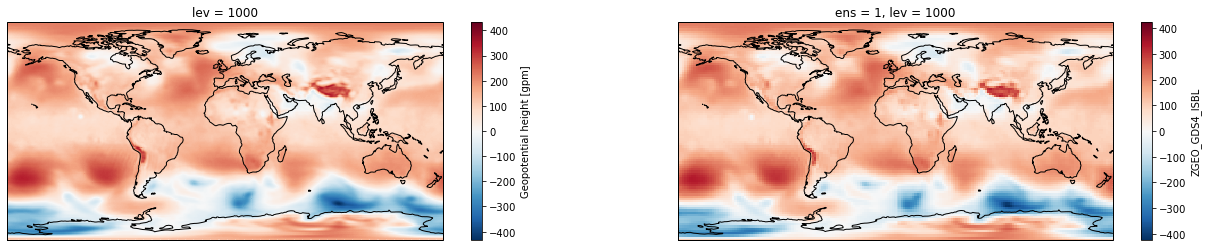

In [11]:
# Plota os campos original e interpolado para verificação
fig, axes = plt.subplots(figsize=(22,4), ncols=2, subplot_kw={"projection": ccrs.PlateCarree()})

zgeo.isel(ens=1,lev=8).plot(ax=axes[0])
zgeo_interp.isel(ens=1,lev=8).plot(ax=axes[1])

for ax in axes:
    ax.coastlines()